I will be accessing the NSIDC snow cover extent data that has been regridded to a 25 km EASE-2.0 grid.

Reference: https://nsidc.org/data/nsidc-0046/versions/4

# Section 1: Data Access
- [x] Step 1: Download the data -- takes close to 8 minutes to get the full record
- [x] Step 2: Download the reference grid
- [x] Step 3: Parse the file names and ensure they are consistent with what is expected; extract dates from file names

In [ ]:
!wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies -r --keep-session-cookies --no-check-certificate --auth-no-challenge=on -r --reject "index.html*" -np -e robots=off https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/

In [ ]:
!wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies -r --keep-session-cookies --no-check-certificate --auth-no-challenge=on -r --reject "index.html*" -np -e robots=off https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0772_easegrids_anc_grid_info/NSIDC0772_LatLon_EASE2_N25km_v1.0.nc

In [4]:
import os
import numpy as np
import datetime as dt

proj_dir = '/users/jk/22/achereque/Paper2/L0_Reference/'
data_loc = os.path.join(proj_dir, 'daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/')

start_dates = []
end_dates = []
fnames = []

for fn in os.listdir(data_loc):

    grid = fn.split('.')[0].split('_')[0]
    resolution = fn.split('.')[0].split('_')[1]
    data_contained = fn.split('.')[1]
    timespan = fn.split('.')[2]
    version = fn.split('.')[3]

    # checking that file names match my expectation
    if ((grid == 'EASE2') and (resolution == 'N25km') and (data_contained == 'snowice') and (version == 'v04')):


        start = timespan.split('-')[0]
        end = timespan.split('-')[1]

        start_y, start_m, start_d = int(start[0:4]), int(start[4:6]), int(start[6:8])
        end_y, end_m, end_d = int(end[0:4]), int(end[4:6]), int(end[6:8])

        start_dates.append(dt.datetime(start_y, start_m, start_d))
        end_dates.append(dt.datetime(end_y, end_m, end_d))

        fnames.append(data_loc + fn)

print('First five filenames:', *fnames[:5], '...\n', sep='\n')
print('First five start dates:', *start_dates[:5], '...\n', sep='\n')
print('First five end dates:', *end_dates[:5], '...\n', sep='\n')


print('Last five filenames:', *fnames[-5:], '...\n', sep='\n')
print('Last five start dates:', *start_dates[-5:], '...\n', sep='\n')

First five filenames:
/users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.19661003-19661009.v04.bin
/users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.19661010-19661016.v04.bin
/users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.19661017-19661023.v04.bin
/users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.19661024-19661030.v04.bin
/users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.19661031-19661106.v04.bin
...

First five start dates:
1966-10-03 00:00:00
1966-10-10 00:00:00
1966-10-17 00:00:00
1966-10-24 00:00:00
1966-10-31 00:00:00
...

First five end dates:
1966-10-09 00:00:00
19

# Section 2: Process data and produce masks

- [x] Step 1: Plot a snapshot of the data as an example
- [x] Step 2: Create a mask that identifies Greenland, North America, and Eurasia
- [x] Step 3: Apply procedure to all files and merge

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar
import copy

import cartopy.crs as ccrs

file in use: /users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.19661212-19661218.v04.bin


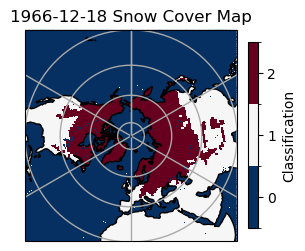

In [11]:
### EXAMPLE 1 ###

path_to_grid = '/users/jk/22/achereque/Paper2/L0_Reference/daacdata.apps.nsidc.org/pub/DATASETS/nsidc0772_easegrids_anc_grid_info/NSIDC0772_LatLon_EASE2_N25km_v1.0.nc'

grid = xr.open_dataset(path_to_grid)

### Using an arbitrary file, here the 10th
print('file in use:', fnames[10])
data = np.fromfile(fnames[10], dtype=np.dtype(np.uint8)).reshape((720, 720)) #open binary file

# Assign values to snow/land/ocean
# See documentation: DOI: 10.5067/P7O0HGJLYUQU
snow_array = np.where((0==data), 1, 0) # snow-free land
snow_array = np.where((5==data)|(1==data), 2, snow_array) # snow
snow_array = np.where((2==data)|(3==data), 0, snow_array) # sea ice --> ocean
snow_array = np.where((253==data)|(4==data)|(255==data), 0, snow_array) #ocean and sea ice

# add to the netcdf file with all the coordinate information
grid['data'] = (('y','x'), snow_array)

# plot to see
projection_of_data = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(ccrs.PlateCarree(), color='darkgrey', linewidth=1)
levs = grid.data.plot(transform=projection_of_data, levels=[-0.5,0.5,1.5,2.5], add_colorbar=False)
plt.colorbar(levs, ax=ax, label='Classification', ticks=[0,1,2], fraction=0.04)
plt.title(str(end_dates[10])[:10]+' Snow Cover Map')
plt.show()

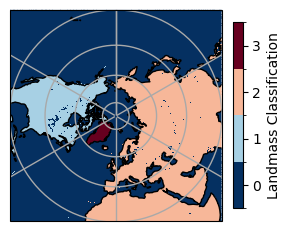

In [12]:
### EXAMPLE 2 ###

# Design a mask for North America, Greenland, and Eurasia.
a = copy.deepcopy(grid.data.values)
a = np.where((a>0), 1., 0.)

a[450:460,250:310] = 3*a[450:460,250:310]
a[415:450,250:350] = 3*a[415:450,250:350]
a[377:415,290:355] = 3*a[377:415,290:355]
a[400:415,280:290] = 3*a[400:415,280:290]
a[375:377,307:312] = 3*a[375:377,307:312]

final_lsmask = np.where(((grid.longitude.values>-25.)|(grid.longitude.values<-170.))&(a!=3), 2*a, a)

grid['lsmask'] = (('y','x'), final_lsmask)

projection_of_data = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(ccrs.PlateCarree(), color='darkgrey', linewidth=1)
grid.lsmask.plot(transform=projection_of_data, levels=[-0.5, 0.5, 1.5, 2.5, 3.5], cbar_kwargs={'label': 'Landmass Classification', 'fraction':0.04, 'ticks':[0,1,2,3]}, ax=ax)


0it [00:00, ?it/s]

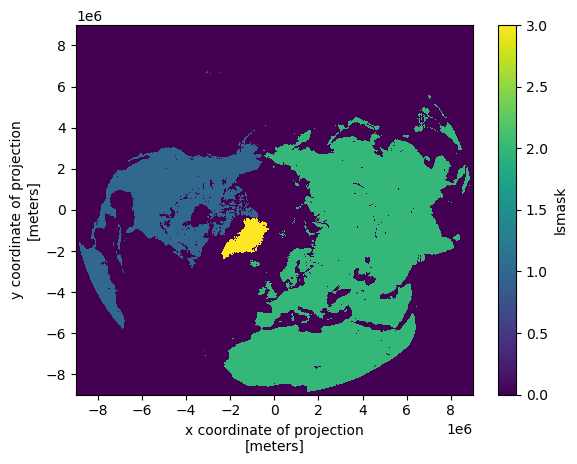

In [13]:
### NOW, PROCESS FULL DATASET ###

full_dataset = xr.open_dataset(path_to_grid)

#update title of Dataset because we are changing it
full_dataset.attrs['title'] = 'EASE2 Grid Information and NH Snow Cover at 25 km resolution.'

snow_stack = np.empty((len(end_dates), 720, 720), dtype=np.uint8)
for ni,nf in tqdm(enumerate(fnames)):
    # read in data from each file
    data = np.fromfile(nf, dtype=np.dtype(np.uint8)).reshape((720, 720))

    # assign points as snow/land/ocean
    snow_array = np.where((0==data), 1, 0) # snow-free land
    snow_array = np.where((5==data)|(1==data), 2, snow_array) # snow
    snow_array = np.where((2==data)|(3==data), 0, snow_array) # sea ice --> ocean
    snow_array = np.where((253==data)|(4==data)|(255==data), 0, snow_array) #ocean and sea ice

    snow_stack[ni,:,:] = snow_array  

full_dataset.coords['time'] = ('time', end_dates)
### Add data to dataset
full_dataset['land_ID'] = (('time', 'y', 'x'), snow_stack)
full_dataset['land_ID'].attrs = {'flag_values': '0 1 2',
                                 'flag_meanings': 'water_or_sea_ice land snow'}
    
### Append land-sea mask and continent info
a = copy.deepcopy(snow_array)
a = np.where((a>0), 1., 0.)

a[450:460,250:310] = 3*a[450:460,250:310]
a[415:450,250:350] = 3*a[415:450,250:350]
a[377:415,290:355] = 3*a[377:415,290:355]
a[400:415,280:290] = 3*a[400:415,280:290]
a[375:377,307:312] = 3*a[375:377,307:312]

final_lsmask = np.where(((full_dataset.longitude.values>-25.)|(full_dataset.longitude.values<-170.))&(a!=3), 2*a, a)

full_dataset['lsmask'] = (('y','x'), final_lsmask)

full_dataset.to_netcdf('/users/jk/22/achereque/Paper2/L0_Reference/NSIDC_EASE2_N25km_v04.nc')

full_dataset['lsmask'].plot()

In [14]:
def calc_NOAA_snow_area(lmm, save_file=False):
    '''Computes snow covered area for different regions using NOAA CDR data.
    
    Parameters:
    -----------
    lmm: latitude min and max limits, as a tuple.
    '''

    #load data
    full_dataset = xr.open_dataset('/users/jk/22/achereque/Paper2/L0_Reference/NSIDC_EASE2_N25km_v04.nc', chunks={'time':10*52})

    lmm_string = f'{lmm[0]}_{lmm[1]}N'

    #calculate continental-scale snow cover
    snow_area_km2 = xr.Dataset()

    snow_area_km2['NAm'] = xr.where((full_dataset.land_ID==2)&(full_dataset.latitude<=lmm[1])&(full_dataset.latitude>=lmm[0])&(full_dataset.lsmask==1), 1, 0).sum(('x','y')) * 25 * 25
    snow_area_km2['NAm'].attrs = {'units':'km2'}

    snow_area_km2['Eur'] = xr.where((full_dataset.land_ID==2)&(full_dataset.latitude<=lmm[1])&(full_dataset.latitude>=lmm[0])&(full_dataset.lsmask==2), 1, 0).sum(('x','y')) * 25 * 25
    snow_area_km2['Eur'].attrs = {'units':'km2'}

    snow_area_km2['Greenland'] = xr.where((full_dataset.land_ID==2)&(full_dataset.latitude<=lmm[1])&(full_dataset.latitude>=lmm[0])&(full_dataset.lsmask==3), 1, 0).sum(('x','y')) * 25 * 25
    snow_area_km2['Greenland'].attrs = {'units':'km2'}

    snow_area_km2.attrs = {'title': 'Snow area in km^2 based on NSIDC_EASE2_N25km_v04.nc'}

    if save_file:
        #save to netcdf
        with ProgressBar():
            snow_area_km2.to_netcdf(f'/users/jk/22/achereque/Paper2/L0_Reference/NSIDC_SCE.weekly.{lmm_string}.nc')
        full_dataset.close()
    else:
        return snow_area_km2
    
calc_NOAA_snow_area([40,90], save_file=True)


[########################################] | 100% Completed | 19.59 ss


# Section 3

- [x] Produce weights for applying NOAA-like resampling to other datasets

In [ ]:
mname = dict(zip(range(1, 13), ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
inv_mname = dict(zip(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], range(1, 13)))

weekly_data = xr.open_dataset('L0_Reference/NSIDC_SCE.weekly.40_90N.nc')

weight_ds = xr.Dataset()
weight_ds['time'] = weekly_data.time

# Loop over each month and assign a weight to the validity date
# Weight should be equal to the number of days that the week
# Ending on the validity dates contributes to the month in question.
for month in range(1, 13):
    date_subset = weekly_data.time.sel(time = weekly_data.time.dt.month.isin([month, month+1]))

    weights = np.zeros(len(date_subset.values))
    for n,i in enumerate(date_subset.indexes['time']):
        #print(i)
        if (i.month == month) & ((i-dt.timedelta(days=6)).month == month):
            weights[n] = 7 #full week falls in month
        elif (i.month != month) & ((i-dt.timedelta(days=6)).month == month):
            weights[n] = 7-i.day #partial week end of month
        elif (i.month == month) & ((i-dt.timedelta(days=6)).month == month-1) & (month != 1):
            weights[n] = i.day #partial week beginning of month
        elif (i.month == 1) & ((i-dt.timedelta(days=6)).month == 12):
            weights[n] = i.day #partial week beginning of month
        else: 
            weights[n] = 0 #full week not in month
            
    weight_ds[mname[month]] = xr.DataArray(data = weights, coords={'time':date_subset}, dims='time')
    
weight_ds.to_netcdf('L0_Reference/NOAA_like.weekly_weights.nc')
